In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

### Data downloading

In [2]:
transform_train = transforms.Compose([
         transforms.Resize((150, 150)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
         transforms.Resize((150, 150)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [3]:
train_data = datasets.ImageFolder('C:/Users/1vany/Desktop/ВКР/raw-890/train', transform=transform_train)
test_data = datasets.ImageFolder('C:/Users/1vany/Desktop/ВКР/raw-890/validation', transform=transform_val)

In [4]:
train_data

Dataset ImageFolder
    Number of datapoints: 765
    Root location: C:/Users/1vany/Desktop/ВКР/raw-890/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
test_data

Dataset ImageFolder
    Number of datapoints: 170
    Root location: C:/Users/1vany/Desktop/ВКР/raw-890/validation
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data)//2, shuffle=True)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [8]:
images.shape, labels.shape

(torch.Size([16, 3, 150, 150]), torch.Size([16]))

Let's visualize any batch from train dataset with marks, where 1 is for "technical" objects

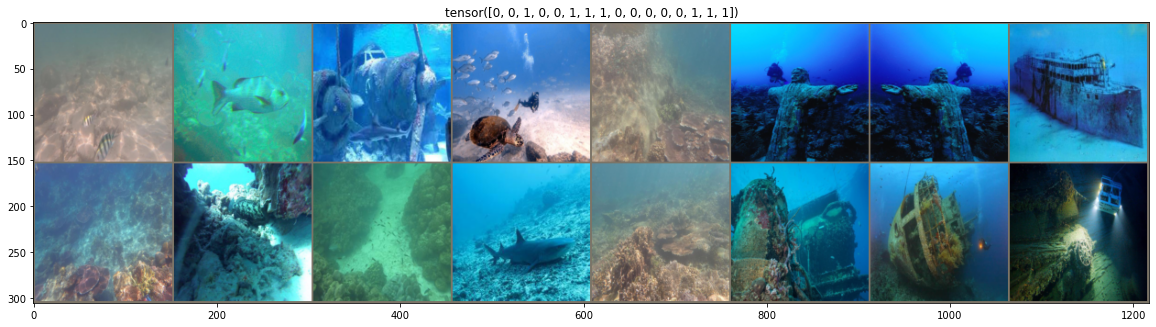

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Take one batch from train dataset
inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)

imshow(out, classes)

In [11]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

### Train
Here and after Train1 using for train model with dataset without restoration and Train2 for preprocessing images

In [12]:
images.shape

torch.Size([16, 3, 150, 150])

In [13]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(20736, 120)  # 5x5 image dimension
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train1(net, n_epoch=3):
    losses = []
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1, 1, 1)
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 3e-4
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in tqdm.notebook.tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm.notebook.tqdm(train_dataiter)):
          # так получаем текущий батч
            X_batch, y_batch = batch
          
          # обнуляем веса
            optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
            loss.backward()
          # обновление весов сети
            optimizer.step()

          # выведем текущий loss
            running_loss += loss.item()
          # выведем качество каждые 500 батчей
            if i % 2 == 1:
                print('[%d, %5d] loss: %.3f, acc: %3f' %
                    (epoch + 1, i + 1, running_loss / 10, accuracy_score(y_batch.numpy(), np.argmax(y_pred.detach().numpy(), axis=1))))
                losses.append(running_loss)
                running_loss = 0.0
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

    print('Обучение закончено')
    return net

In [15]:
from torch import nn, optim

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

[1,     2] loss: 0.138, acc: 0.687500
[1,     4] loss: 0.136, acc: 0.625000
[1,     6] loss: 0.144, acc: 0.625000
[1,     8] loss: 0.125, acc: 0.625000
[1,    10] loss: 0.134, acc: 0.625000
[1,    12] loss: 0.146, acc: 0.500000
[1,    14] loss: 0.143, acc: 0.437500
[1,    16] loss: 0.125, acc: 0.562500
[1,    18] loss: 0.137, acc: 0.625000
[1,    20] loss: 0.136, acc: 0.562500
[1,    22] loss: 0.126, acc: 0.812500
[1,    24] loss: 0.141, acc: 0.687500
[1,    26] loss: 0.117, acc: 0.687500
[1,    28] loss: 0.121, acc: 0.687500
[1,    30] loss: 0.107, acc: 0.750000
[1,    32] loss: 0.122, acc: 0.625000
[1,    34] loss: 0.121, acc: 0.750000
[1,    36] loss: 0.117, acc: 0.687500
[1,    38] loss: 0.097, acc: 0.750000
[1,    40] loss: 0.123, acc: 0.875000
[1,    42] loss: 0.104, acc: 0.875000
[1,    44] loss: 0.100, acc: 0.687500
[1,    46] loss: 0.112, acc: 0.687500
[1,    48] loss: 0.102, acc: 0.846154


  0%|          | 0/48 [00:00<?, ?it/s]

[2,     2] loss: 0.133, acc: 0.687500
[2,     4] loss: 0.099, acc: 0.750000
[2,     6] loss: 0.102, acc: 0.687500
[2,     8] loss: 0.153, acc: 0.562500
[2,    10] loss: 0.084, acc: 0.750000
[2,    12] loss: 0.094, acc: 0.625000
[2,    14] loss: 0.088, acc: 0.687500
[2,    16] loss: 0.089, acc: 0.937500
[2,    18] loss: 0.086, acc: 0.812500
[2,    20] loss: 0.099, acc: 0.812500
[2,    22] loss: 0.118, acc: 0.687500
[2,    24] loss: 0.092, acc: 0.937500
[2,    26] loss: 0.101, acc: 0.687500
[2,    28] loss: 0.082, acc: 0.875000
[2,    30] loss: 0.094, acc: 0.687500
[2,    32] loss: 0.095, acc: 0.750000
[2,    34] loss: 0.092, acc: 0.687500
[2,    36] loss: 0.062, acc: 0.812500
[2,    38] loss: 0.107, acc: 0.875000
[2,    40] loss: 0.111, acc: 0.875000
[2,    42] loss: 0.081, acc: 0.687500
[2,    44] loss: 0.138, acc: 0.500000
[2,    46] loss: 0.122, acc: 0.625000
[2,    48] loss: 0.083, acc: 0.923077


  0%|          | 0/48 [00:00<?, ?it/s]

[3,     2] loss: 0.100, acc: 0.562500
[3,     4] loss: 0.083, acc: 0.812500
[3,     6] loss: 0.110, acc: 0.687500
[3,     8] loss: 0.101, acc: 0.562500
[3,    10] loss: 0.090, acc: 0.812500
[3,    12] loss: 0.096, acc: 0.937500
[3,    14] loss: 0.124, acc: 0.625000
[3,    16] loss: 0.088, acc: 1.000000
[3,    18] loss: 0.092, acc: 0.812500
[3,    20] loss: 0.107, acc: 0.687500
[3,    22] loss: 0.095, acc: 0.812500
[3,    24] loss: 0.072, acc: 0.812500
[3,    26] loss: 0.108, acc: 0.812500
[3,    28] loss: 0.113, acc: 0.750000
[3,    30] loss: 0.127, acc: 0.500000
[3,    32] loss: 0.103, acc: 0.937500
[3,    34] loss: 0.070, acc: 1.000000
[3,    36] loss: 0.100, acc: 0.750000
[3,    38] loss: 0.074, acc: 0.875000
[3,    40] loss: 0.091, acc: 0.875000
[3,    42] loss: 0.089, acc: 0.812500
[3,    44] loss: 0.126, acc: 0.500000
[3,    46] loss: 0.093, acc: 0.875000
[3,    48] loss: 0.118, acc: 0.692308


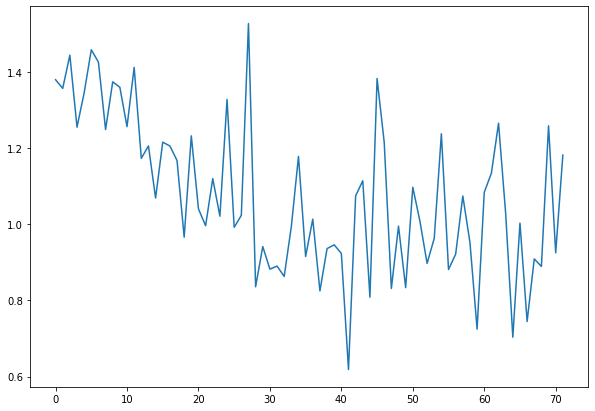

Обучение закончено


In [16]:
# create a model object
net = ModelDropout()
net = train1(net)

In [17]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [104]:
Ans = np.argmax(net.forward(images).detach().numpy(), axis=1)

In [105]:
accuracy_score(labels.numpy(), Ans)

0.8352941176470589

### Visualization of test with validation dataset

In [21]:
def comment(lbl):
    if lbl == 0:
        return 'Nature'
    else:
        return 'Technical'

In [212]:
def illustrator(imgs, lbls, ans):
    plt.figure(figsize=(32, 16))
    for i in range(len(lbls)):
        plt.subplot(2,8, i+1)
        im = imgs[i].numpy().transpose((1, 2, 0))  
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean
        plt.imshow(im)
        if ans[i] == 0:
            plt.title("Predicted: Nature \n" + "Real: {real}".format(real = comment(lbls[i])))
        else: 
            plt.title("Predicted: Technical \n" + "Real: {real}".format(real = comment(lbls[i])))
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


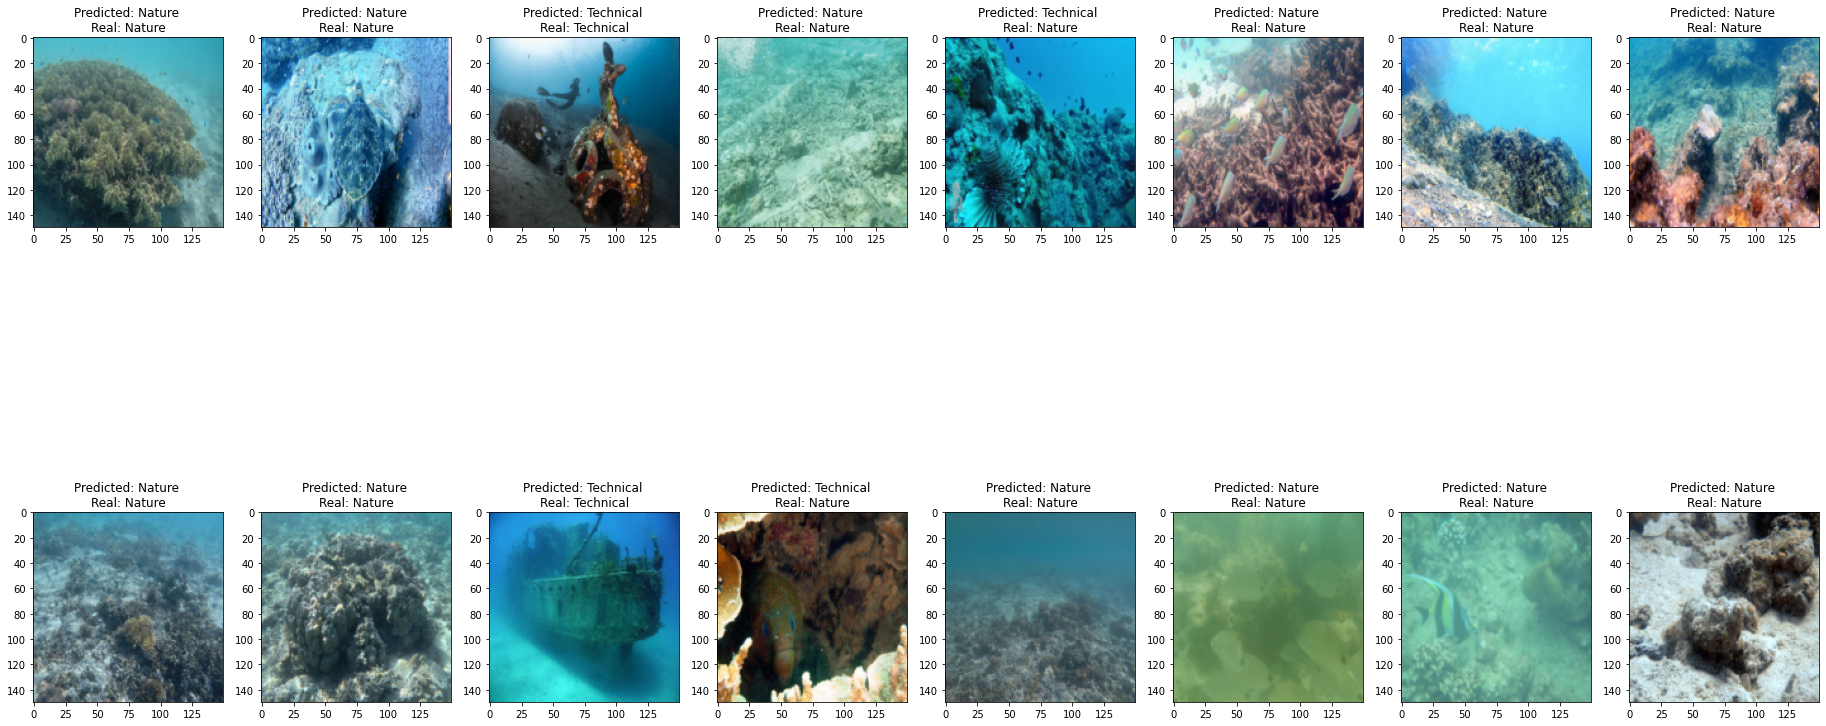

In [213]:
illustrator(images[:16], labels[:16], Ans[:16])

Here we can see some mistakes, but it's okay

## Train on preprocessed images

In [24]:
train2_data = datasets.ImageFolder('C:/Users/1vany/Desktop/ВКР/raw-890/train_fixed', transform=transform_train)
test2_data = datasets.ImageFolder('C:/Users/1vany/Desktop/ВКР/raw-890/val_fixed', transform=transform_val)

In [25]:
train2_loader = torch.utils.data.DataLoader(train2_data, batch_size=16, shuffle=True)
test2_loader = torch.utils.data.DataLoader(test2_data, batch_size=len(test_data)//2, shuffle=True)

In [26]:
train2_data

Dataset ImageFolder
    Number of datapoints: 767
    Root location: C:/Users/1vany/Desktop/ВКР/raw-890/train_fixed
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [27]:
dataiter2 = iter(train2_loader)
images2, labels2 = dataiter2.next()

In [28]:
images2.shape, labels2.shape

(torch.Size([16, 3, 150, 150]), torch.Size([16]))

In [30]:
def train2(net, n_epoch=3):
    losses = []
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(1, 1, 1)
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 3e-4
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in tqdm.notebook.tqdm(range(n_epoch)):

        running_loss = 0.0
        train2_dataiter = iter(train2_loader)
        for i, batch in enumerate(tqdm.notebook.tqdm(train2_dataiter)):
          # так получаем текущий батч
            X_batch, y_batch = batch
          
          # обнуляем веса
            optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
            loss.backward()
          # обновление весов сети
            optimizer.step()

          # выведем текущий loss
            running_loss += loss.item()
          # выведем качество каждые 10 батчей
            if i % 2 == 1:
                print('[%d, %5d] loss: %.3f, acc: %3f' %
                    (epoch + 1, i + 1, running_loss / 10, accuracy_score(y_batch.numpy(), np.argmax(y_pred.detach().numpy(), axis=1))))
                losses.append(running_loss)
                running_loss = 0.0
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

    print('Обучение закончено')
    return net

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

[1,     2] loss: 0.136, acc: 0.500000
[1,     4] loss: 0.143, acc: 0.375000
[1,     6] loss: 0.130, acc: 0.562500
[1,     8] loss: 0.127, acc: 0.562500
[1,    10] loss: 0.119, acc: 0.687500
[1,    12] loss: 0.136, acc: 0.562500
[1,    14] loss: 0.113, acc: 0.687500
[1,    16] loss: 0.132, acc: 0.875000
[1,    18] loss: 0.122, acc: 0.625000
[1,    20] loss: 0.104, acc: 0.750000
[1,    22] loss: 0.110, acc: 0.750000
[1,    24] loss: 0.116, acc: 0.687500
[1,    26] loss: 0.127, acc: 0.625000
[1,    28] loss: 0.127, acc: 0.750000
[1,    30] loss: 0.111, acc: 0.750000
[1,    32] loss: 0.163, acc: 0.500000
[1,    34] loss: 0.106, acc: 0.812500
[1,    36] loss: 0.120, acc: 0.625000
[1,    38] loss: 0.102, acc: 0.625000
[1,    40] loss: 0.134, acc: 0.625000
[1,    42] loss: 0.111, acc: 0.750000
[1,    44] loss: 0.094, acc: 0.750000
[1,    46] loss: 0.127, acc: 0.687500
[1,    48] loss: 0.104, acc: 0.800000


  0%|          | 0/48 [00:00<?, ?it/s]

[2,     2] loss: 0.096, acc: 0.750000
[2,     4] loss: 0.148, acc: 0.500000
[2,     6] loss: 0.118, acc: 0.750000
[2,     8] loss: 0.104, acc: 0.875000
[2,    10] loss: 0.103, acc: 0.687500
[2,    12] loss: 0.106, acc: 0.625000
[2,    14] loss: 0.114, acc: 0.812500
[2,    16] loss: 0.101, acc: 0.875000
[2,    18] loss: 0.104, acc: 0.812500
[2,    20] loss: 0.106, acc: 0.687500
[2,    22] loss: 0.093, acc: 0.875000
[2,    24] loss: 0.123, acc: 0.687500
[2,    26] loss: 0.097, acc: 0.937500
[2,    28] loss: 0.141, acc: 0.875000
[2,    30] loss: 0.112, acc: 0.687500
[2,    32] loss: 0.090, acc: 0.750000
[2,    34] loss: 0.111, acc: 0.750000
[2,    36] loss: 0.113, acc: 0.812500
[2,    38] loss: 0.092, acc: 0.812500
[2,    40] loss: 0.073, acc: 0.937500
[2,    42] loss: 0.103, acc: 0.750000
[2,    44] loss: 0.110, acc: 0.687500
[2,    46] loss: 0.075, acc: 0.750000
[2,    48] loss: 0.074, acc: 0.800000


  0%|          | 0/48 [00:00<?, ?it/s]

[3,     2] loss: 0.088, acc: 0.875000
[3,     4] loss: 0.110, acc: 0.625000
[3,     6] loss: 0.107, acc: 0.812500
[3,     8] loss: 0.087, acc: 0.687500
[3,    10] loss: 0.063, acc: 0.875000
[3,    12] loss: 0.077, acc: 0.812500
[3,    14] loss: 0.105, acc: 0.750000
[3,    16] loss: 0.066, acc: 0.937500
[3,    18] loss: 0.095, acc: 0.750000
[3,    20] loss: 0.077, acc: 0.875000
[3,    22] loss: 0.106, acc: 0.875000
[3,    24] loss: 0.122, acc: 0.562500
[3,    26] loss: 0.114, acc: 0.625000
[3,    28] loss: 0.083, acc: 0.812500
[3,    30] loss: 0.092, acc: 0.875000
[3,    32] loss: 0.091, acc: 0.750000
[3,    34] loss: 0.093, acc: 0.687500
[3,    36] loss: 0.069, acc: 0.937500
[3,    38] loss: 0.146, acc: 0.687500
[3,    40] loss: 0.107, acc: 0.750000
[3,    42] loss: 0.098, acc: 0.812500
[3,    44] loss: 0.099, acc: 0.812500
[3,    46] loss: 0.111, acc: 0.562500
[3,    48] loss: 0.086, acc: 0.866667


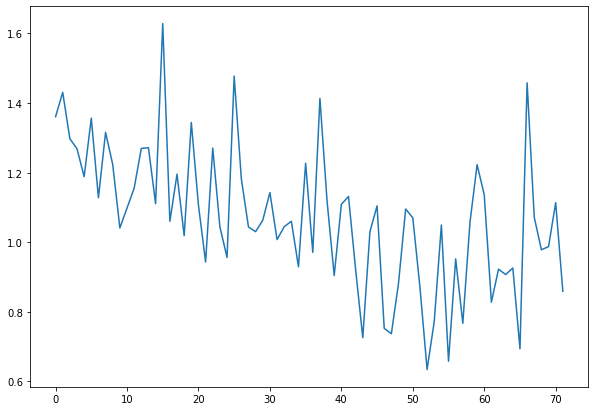

Обучение закончено


In [31]:
net2 = ModelDropout()
net2 = train2(net2)

In [162]:
Ans2 = np.argmax(net2.forward(images).detach().numpy(), axis=1)

In [163]:
accuracy_score(labels.numpy(), Ans2)

0.7411764705882353

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


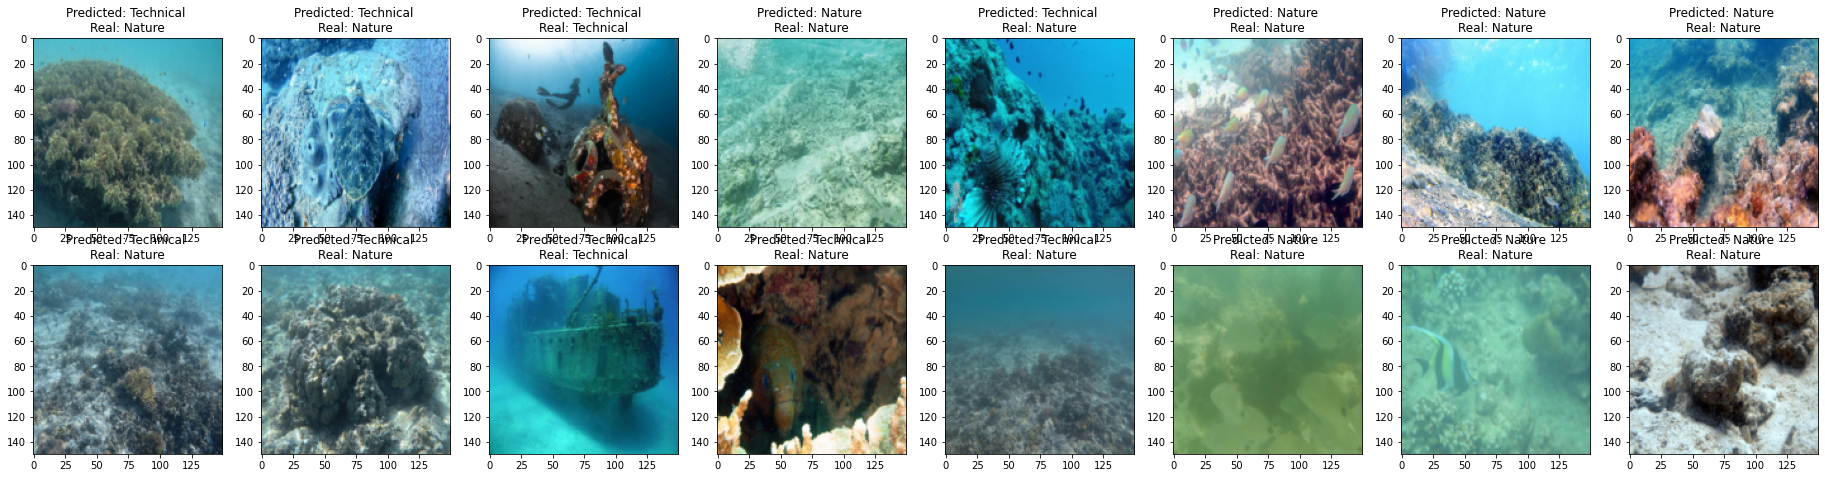

In [203]:
illustrator(images[:16], labels[:16], Ans2[:16])

We can see more mistakes

## Transfer learning
First step for natural images and second is for preprocessed

In [36]:
from torchvision import models
AlexNet = models.alexnet(pretrained=True)

In [37]:
AlexNet.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

In [38]:
AlexNet.classifier = nn.Sequential(*list(AlexNet.classifier.children()))[:-1]

In [39]:
AlexNet.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

In [40]:
class New_AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.alex_net = AlexNet
        for param in self.alex_net.features.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(4096, 2)

    
    def forward(self, x):

        x = self.alex_net(x)
        x = self.fc(x)
        
        return x

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

[1,     2] loss: 0.151, acc: 0.562500
[1,     4] loss: 0.103, acc: 0.750000
[1,     6] loss: 0.172, acc: 0.687500
[1,     8] loss: 0.124, acc: 0.812500
[1,    10] loss: 0.058, acc: 0.875000
[1,    12] loss: 0.135, acc: 0.875000
[1,    14] loss: 0.062, acc: 0.875000
[1,    16] loss: 0.159, acc: 0.937500
[1,    18] loss: 0.123, acc: 1.000000
[1,    20] loss: 0.105, acc: 0.812500
[1,    22] loss: 0.131, acc: 0.812500
[1,    24] loss: 0.118, acc: 0.687500
[1,    26] loss: 0.027, acc: 0.937500
[1,    28] loss: 0.084, acc: 0.812500
[1,    30] loss: 0.085, acc: 0.875000
[1,    32] loss: 0.091, acc: 0.750000
[1,    34] loss: 0.060, acc: 0.875000
[1,    36] loss: 0.042, acc: 0.937500
[1,    38] loss: 0.119, acc: 0.812500
[1,    40] loss: 0.110, acc: 0.875000
[1,    42] loss: 0.072, acc: 0.812500
[1,    44] loss: 0.071, acc: 1.000000
[1,    46] loss: 0.146, acc: 0.812500
[1,    48] loss: 0.074, acc: 0.923077


  0%|          | 0/48 [00:00<?, ?it/s]

[2,     2] loss: 0.021, acc: 1.000000
[2,     4] loss: 0.057, acc: 0.750000
[2,     6] loss: 0.104, acc: 0.875000
[2,     8] loss: 0.030, acc: 0.937500
[2,    10] loss: 0.050, acc: 0.875000
[2,    12] loss: 0.026, acc: 0.812500
[2,    14] loss: 0.012, acc: 0.937500
[2,    16] loss: 0.009, acc: 0.937500
[2,    18] loss: 0.022, acc: 1.000000
[2,    20] loss: 0.042, acc: 0.937500
[2,    22] loss: 0.053, acc: 0.937500
[2,    24] loss: 0.035, acc: 0.937500
[2,    26] loss: 0.043, acc: 0.937500
[2,    28] loss: 0.048, acc: 0.875000
[2,    30] loss: 0.038, acc: 0.937500
[2,    32] loss: 0.032, acc: 1.000000
[2,    34] loss: 0.004, acc: 1.000000
[2,    36] loss: 0.038, acc: 1.000000
[2,    38] loss: 0.062, acc: 0.937500
[2,    40] loss: 0.033, acc: 0.875000
[2,    42] loss: 0.088, acc: 0.937500
[2,    44] loss: 0.025, acc: 0.937500
[2,    46] loss: 0.054, acc: 0.937500
[2,    48] loss: 0.113, acc: 0.846154


  0%|          | 0/48 [00:00<?, ?it/s]

[3,     2] loss: 0.034, acc: 0.937500
[3,     4] loss: 0.028, acc: 0.937500
[3,     6] loss: 0.035, acc: 0.937500
[3,     8] loss: 0.005, acc: 1.000000
[3,    10] loss: 0.008, acc: 1.000000
[3,    12] loss: 0.022, acc: 0.937500
[3,    14] loss: 0.016, acc: 0.937500
[3,    16] loss: 0.005, acc: 1.000000
[3,    18] loss: 0.009, acc: 1.000000
[3,    20] loss: 0.011, acc: 0.937500
[3,    22] loss: 0.046, acc: 0.937500
[3,    24] loss: 0.014, acc: 0.937500
[3,    26] loss: 0.010, acc: 0.937500
[3,    28] loss: 0.010, acc: 1.000000
[3,    30] loss: 0.079, acc: 0.937500
[3,    32] loss: 0.035, acc: 1.000000
[3,    34] loss: 0.017, acc: 0.937500
[3,    36] loss: 0.081, acc: 0.937500
[3,    38] loss: 0.020, acc: 0.937500
[3,    40] loss: 0.082, acc: 0.937500
[3,    42] loss: 0.078, acc: 0.937500
[3,    44] loss: 0.017, acc: 0.937500
[3,    46] loss: 0.064, acc: 0.875000
[3,    48] loss: 0.015, acc: 1.000000


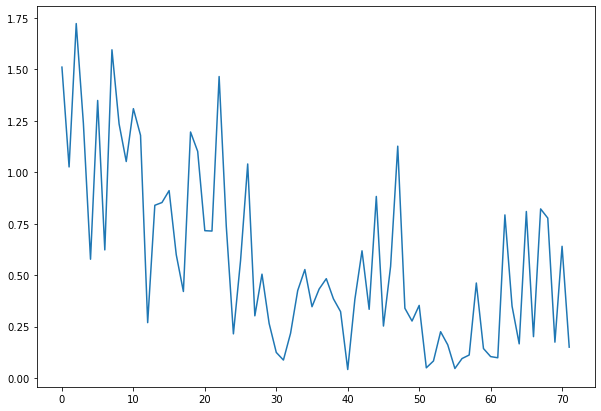

Обучение закончено


New_AlexNet(
  (alex_net): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
  

In [41]:
net3 = New_AlexNet()
train1(net3)

In [90]:
Ans3 = np.argmax(net3.forward(images).detach().numpy(), axis=1)

In [91]:
accuracy_score(labels.numpy(), Ans3)

0.8470588235294118

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


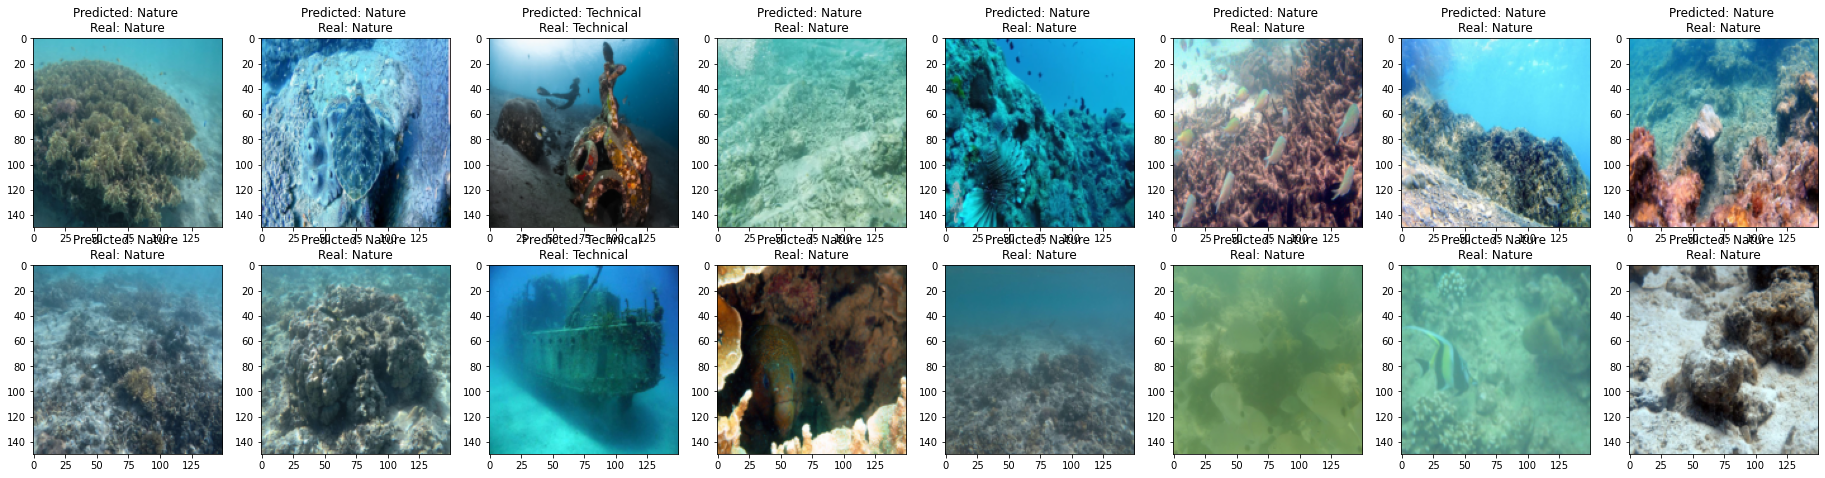

In [205]:
illustrator(images[:16], labels[:16], Ans3[:16])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

[1,     2] loss: 0.111, acc: 0.875000
[1,     4] loss: 0.030, acc: 1.000000
[1,     6] loss: 0.021, acc: 1.000000
[1,     8] loss: 0.093, acc: 0.937500
[1,    10] loss: 0.106, acc: 0.937500
[1,    12] loss: 0.067, acc: 0.875000
[1,    14] loss: 0.015, acc: 0.937500
[1,    16] loss: 0.002, acc: 1.000000
[1,    18] loss: 0.057, acc: 0.875000
[1,    20] loss: 0.121, acc: 0.937500
[1,    22] loss: 0.075, acc: 0.812500
[1,    24] loss: 0.011, acc: 1.000000
[1,    26] loss: 0.056, acc: 0.937500
[1,    28] loss: 0.054, acc: 0.875000
[1,    30] loss: 0.014, acc: 1.000000
[1,    32] loss: 0.114, acc: 0.875000
[1,    34] loss: 0.031, acc: 1.000000
[1,    36] loss: 0.001, acc: 1.000000
[1,    38] loss: 0.006, acc: 1.000000
[1,    40] loss: 0.105, acc: 0.937500
[1,    42] loss: 0.027, acc: 0.937500
[1,    44] loss: 0.007, acc: 0.937500
[1,    46] loss: 0.214, acc: 0.937500
[1,    48] loss: 0.013, acc: 0.933333


  0%|          | 0/48 [00:00<?, ?it/s]

[2,     2] loss: 0.025, acc: 0.937500
[2,     4] loss: 0.029, acc: 1.000000
[2,     6] loss: 0.058, acc: 0.937500
[2,     8] loss: 0.004, acc: 1.000000
[2,    10] loss: 0.002, acc: 1.000000
[2,    12] loss: 0.021, acc: 0.937500
[2,    14] loss: 0.048, acc: 0.937500
[2,    16] loss: 0.006, acc: 1.000000
[2,    18] loss: 0.034, acc: 0.875000
[2,    20] loss: 0.004, acc: 1.000000
[2,    22] loss: 0.014, acc: 1.000000
[2,    24] loss: 0.132, acc: 0.937500
[2,    26] loss: 0.000, acc: 1.000000
[2,    28] loss: 0.038, acc: 0.875000
[2,    30] loss: 0.015, acc: 0.937500
[2,    32] loss: 0.008, acc: 1.000000
[2,    34] loss: 0.055, acc: 0.875000
[2,    36] loss: 0.061, acc: 0.875000
[2,    38] loss: 0.008, acc: 1.000000
[2,    40] loss: 0.012, acc: 1.000000
[2,    42] loss: 0.026, acc: 1.000000
[2,    44] loss: 0.141, acc: 0.875000
[2,    46] loss: 0.003, acc: 1.000000
[2,    48] loss: 0.026, acc: 0.933333


  0%|          | 0/48 [00:00<?, ?it/s]

[3,     2] loss: 0.006, acc: 1.000000
[3,     4] loss: 0.014, acc: 0.937500
[3,     6] loss: 0.001, acc: 1.000000
[3,     8] loss: 0.004, acc: 1.000000
[3,    10] loss: 0.001, acc: 1.000000
[3,    12] loss: 0.001, acc: 1.000000
[3,    14] loss: 0.017, acc: 1.000000
[3,    16] loss: 0.001, acc: 1.000000
[3,    18] loss: 0.000, acc: 1.000000
[3,    20] loss: 0.013, acc: 1.000000
[3,    22] loss: 0.001, acc: 1.000000
[3,    24] loss: 0.029, acc: 0.875000
[3,    26] loss: 0.048, acc: 0.937500
[3,    28] loss: 0.003, acc: 1.000000
[3,    30] loss: 0.014, acc: 1.000000
[3,    32] loss: 0.039, acc: 0.875000
[3,    34] loss: 0.009, acc: 1.000000
[3,    36] loss: 0.001, acc: 1.000000
[3,    38] loss: 0.031, acc: 1.000000
[3,    40] loss: 0.062, acc: 0.937500
[3,    42] loss: 0.003, acc: 1.000000
[3,    44] loss: 0.046, acc: 1.000000
[3,    46] loss: 0.004, acc: 1.000000
[3,    48] loss: 0.000, acc: 1.000000


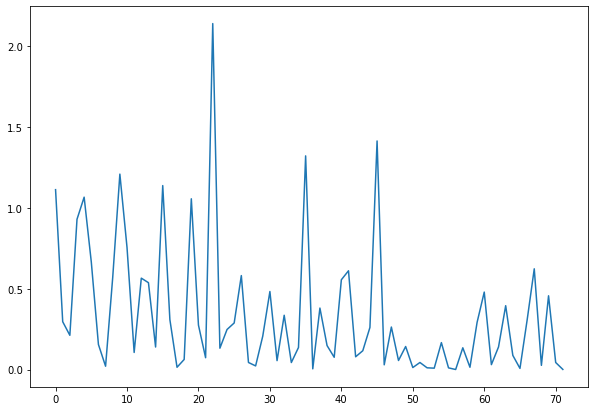

Обучение закончено


New_AlexNet(
  (alex_net): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
  

In [45]:
net4 = New_AlexNet()
train2(net4)

In [227]:
Ans4 = np.argmax(net4.forward(images).detach().numpy(), axis=1)

In [228]:
accuracy_score(labels.numpy(), Ans4)

0.8941176470588236

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


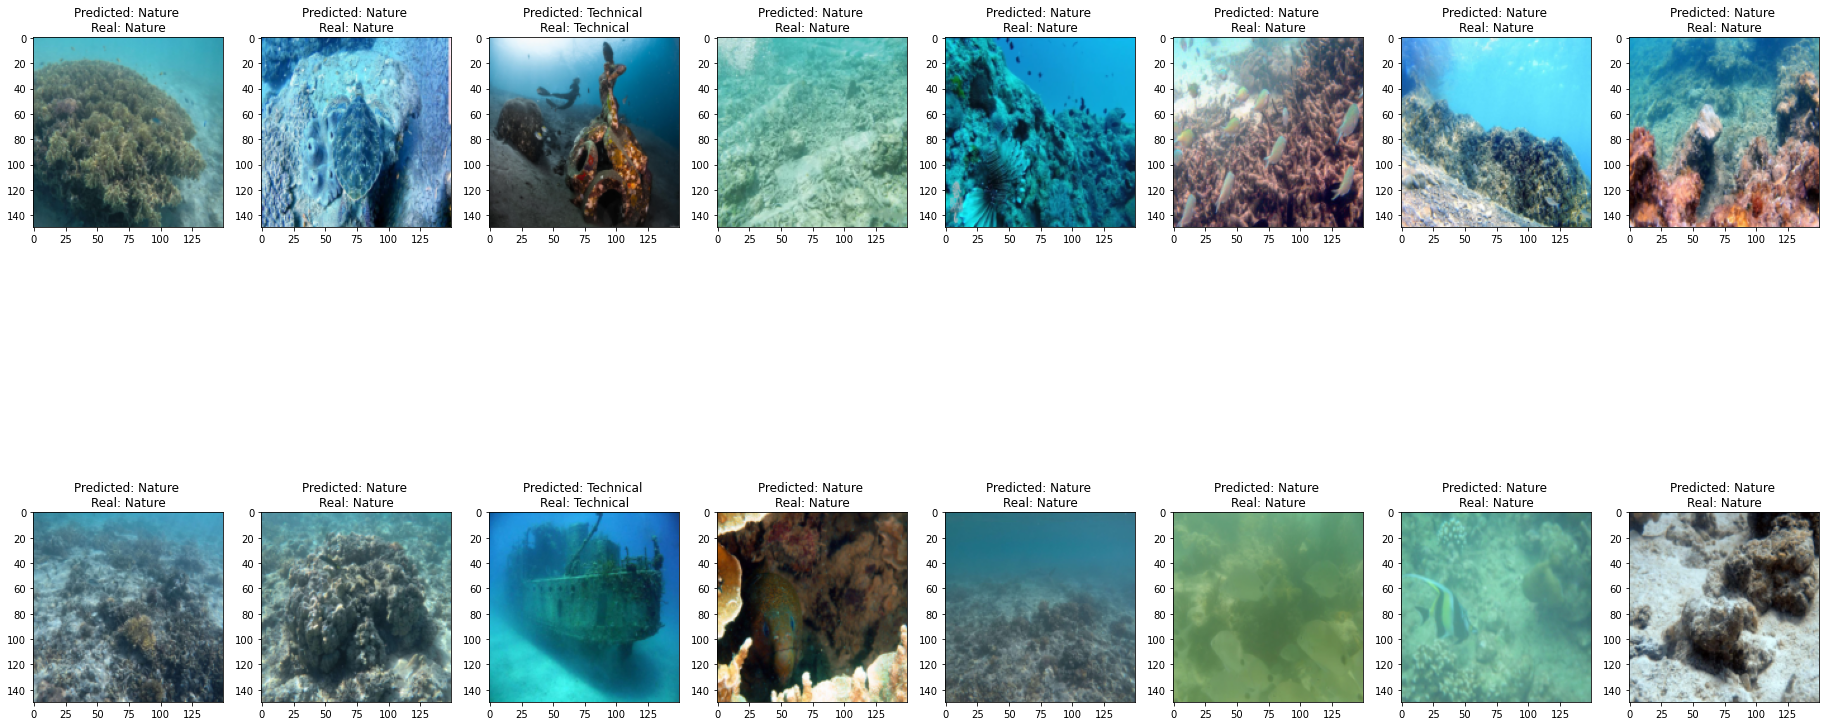

In [229]:
illustrator(images[:16], labels[:16], Ans4[:16])